In [3]:
! pip install scikit-learn pandas numpy

Defaulting to user installation because normal site-packages is not writeable


1. Dataset contains Monthly and Daily prices of Natural gas, starting from January 1997 to current
year. Prices are in nominal dollars. The task is to predict the price of natural gas using LSTM model
for the dataset
https://datahub.io/core/natural-gas#resource-daily or
https://www.kaggle.com/datasets/joebeachcapital/natural-gas-prices
Given the price of last ten 10 days, corresponds to sequence_length, the LSTM model must predict
the price for the 11th day

0 th iteration :  0.04467422142624855
50 th iteration :  0.010443519800901413
100 th iteration :  0.0030527275521308184
150 th iteration :  0.0026112711057066917
200 th iteration :  0.0005146440234966576
250 th iteration :  0.0009433942614123225
300 th iteration :  0.0005945205339230597
350 th iteration :  0.001024755765683949
400 th iteration :  0.00042441842379048467
450 th iteration :  0.0009617086034268141
500 th iteration :  0.0005369627033360302
550 th iteration :  0.0003148133400827646
600 th iteration :  0.0002874044585041702
650 th iteration :  0.00035399702028371394
700 th iteration :  0.0005848530563525856
750 th iteration :  0.0003373103099875152
800 th iteration :  0.00037416210398077965
850 th iteration :  0.00037261657416820526
900 th iteration :  0.00020901647803839296
950 th iteration :  0.00022871016699355096
1000 th iteration :  0.0002558521809987724
1050 th iteration :  0.0003715741040650755
1100 th iteration :  0.00030316735501401126
1150 th iteration :  0.00014518

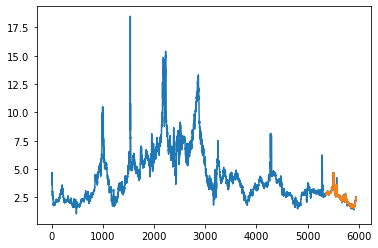

In [5]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import matplotlib.pyplot as plt

df = pd.read_csv("daily_csv.csv")
df = df.dropna()
y = df['Price'].values
minm = y.min()
maxm = y.max()
y = (y - minm) / (maxm - minm)

Sequence_Length = 10
X = []
Y = []
for i in range(0, len(y) - Sequence_Length):
    list1 = []
    for j in range(i, i + Sequence_Length):
        list1.append(y[j])
    X.append(list1)
    Y.append(y[i + Sequence_Length])

X = np.array(X)
Y = np.array(Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42, shuffle=False, stratify=None)

class NGTimeSeries(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.len

dataset = NGTimeSeries(x_train, y_train)
train_loader = DataLoader(dataset, shuffle=True, batch_size=256)

class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=5, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        output, _status = self.lstm(x)
        output = output[:, -1, :]
        output = self.fc1(torch.relu(output))
        return output

model = LSTMModel()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 1500
for i in range(epochs):
    for j, data in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(data[0].view(-1, Sequence_Length, 1)).reshape(-1)
        loss = criterion(y_pred, data[1])
        loss.backward()
        optimizer.step()
    if i % 50 == 0:
        print(i, "th iteration : ", loss.item())

test_set = NGTimeSeries(x_test, y_test)
model.eval()
with torch.no_grad():
    test_pred = model(test_set[:][0].view(-1, Sequence_Length, 1)).view(-1)


y = y * (maxm - minm) + minm
y_pred = test_pred.numpy() * (maxm - minm) + minm

plt.plot(y)
plt.plot(range(len(y) - len(y_pred), len(y)), y_pred)
plt.show()


2. The data provided at the link https://download.pytorch.org/tutorial/data.zip consists of
names stored in the format {language: [names ...]} i.e. each language contains a list of
names. Train a LSTM on a few thousand surnames from 18 languages of origin, and
predict which language a name is from based on the spelling.

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import glob
import unicodedata
import string
from sklearn.model_selection import train_test_split


def unicode_to_ascii(s, all_letters):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def load_data(data_path):
    all_categories = []
    category_lines = {}
    all_letters = string.ascii_letters + " .,;'"
    n_letters = len(all_letters)

    for filename in glob.glob(os.path.join(data_path, '*.txt')):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)
        with open(filename, encoding='utf-8') as file:
            lines = file.read().strip().split('\n') 
        lines = [unicode_to_ascii(line, all_letters) for line in lines]  
        category_lines[category] = lines

    return category_lines, all_categories, n_letters, all_letters



def name_to_tensor(name, all_letters, n_letters):
    tensor = torch.zeros(len(name), 1, n_letters)
    for li, letter in enumerate(name):
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        output, _ = self.lstm(input)
        output = self.linear(output[-1])
        output = self.softmax(output)
        return output

def random_choice(a):
    random_idx = np.random.randint(0, len(a))
    return a[random_idx]

def random_training_example(category_lines, all_categories, all_letters, n_letters):
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = name_to_tensor(line, all_letters, n_letters)
    return category, line, category_tensor, line_tensor

def train(category_tensor, line_tensor, model, criterion, optimizer):
    optimizer.zero_grad()
    output = model(line_tensor)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    return output, loss.item()

def category_from_output(output, all_categories):
    top_n, top_i = output.topk(1)  
    category_i = top_i[0].item()  
    return all_categories[category_i], category_i  

import time
import math

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


if __name__ == '__main__':
   
    start = time.time()

    data_path = '/home/student/Jayasuryan_DL_Lab/names'
    category_lines, all_categories, n_letters, all_letters = load_data(data_path)
    n_categories = len(all_categories)

    n_hidden = 128
    model = LSTM(n_letters, n_hidden, n_categories)
    criterion = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.005)

    n_iters = 100000
    print_every = 5000
    plot_every = 1000

    current_loss = 0
    all_losses = []

    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories, all_letters, n_letters)
        output, loss = train(category_tensor, line_tensor, model, criterion, optimizer)
        current_loss += loss

        if iter % print_every == 0:
            guess, guess_i = category_from_output(output, all_categories)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0



5000 5% (0m 4s) 2.8686 Simpson / English ✗ (Scottish)
10000 10% (0m 8s) 2.8786 D'cruze / French ✗ (Portuguese)
15000 15% (0m 12s) 2.8054 Winograd / Czech ✗ (Polish)
20000 20% (0m 17s) 2.7581 Thuy / Vietnamese ✓
25000 25% (0m 21s) 2.5428 Gasymov / Russian ✓
30000 30% (0m 25s) 2.5731 Asahi / Arabic ✗ (Japanese)
35000 35% (0m 31s) 2.4862 Basurto / Portuguese ✗ (Italian)
40000 40% (0m 36s) 2.0676 Rayner / German ✗ (English)
45000 45% (0m 40s) 0.9812 Balboni / Italian ✓
50000 50% (0m 43s) 1.7433 Curran / English ✗ (Irish)
55000 55% (0m 47s) 0.9116 Tang / Chinese ✓
60000 60% (0m 51s) 1.5755 Tong / Chinese ✗ (Vietnamese)
65000 65% (0m 55s) 2.4308 Kranz / Spanish ✗ (German)
70000 70% (0m 59s) 1.0760 Geier / German ✓
75000 75% (1m 3s) 1.5605 Sarraf / Arabic ✓
80000 80% (1m 6s) 1.3952 Rizzo / Portuguese ✗ (Italian)
85000 85% (1m 10s) 0.0746 Kotsilimbas / Greek ✓
90000 90% (1m 14s) 0.7953 Han / Chinese ✓
95000 95% (1m 18s) 1.6593 Sneijer / German ✗ (Dutch)
100000 100% (1m 22s) 1.1235 Bazzi / Arab

3. Implement a next character predictor using LSTM Model

In [16]:
import torch
import torch.nn as nn
import numpy as np

text = "This is a simple example text for next character prediction."

chars = sorted(set(text))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}
n_chars = len(chars)

seq_length = 10
inputs = []
targets = []

for i in range(0, len(text) - seq_length):
    input_seq = text[i:i + seq_length]
    target_char = text[i + seq_length]
    inputs.append([char_to_int[char] for char in input_seq])
    targets.append(char_to_int[target_char])

inputs_tensor = torch.FloatTensor(inputs).reshape(-1, seq_length, 1) / n_chars
targets_tensor = torch.LongTensor(targets)

class CharPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(CharPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        hidden = (torch.zeros(self.n_layers, batch_size, self.hidden_size).to(x.device),
                  torch.zeros(self.n_layers, batch_size, self.hidden_size).to(x.device))
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out[:, -1, :])
        return out

input_size = 1  
hidden_size = 256
output_size = n_chars
n_layers = 2

model = CharPredictor(input_size, hidden_size, output_size, n_layers)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.train()
n_epochs = 100  

for epoch in range(n_epochs):
    total_loss = 0

    for i in range(inputs_tensor.size(0)):
        optimizer.zero_grad()
        input_seq = inputs_tensor[i:i+1]  
        target = targets_tensor[i]

        output = model(input_seq)
        loss = criterion(output, target.unsqueeze(0))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if epoch % 10 == 0:  
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {total_loss/len(inputs)}')

print("Training completed.")


Epoch 1/100, Loss: 2.9505160570144655
Epoch 11/100, Loss: 2.7492283844947814
Epoch 21/100, Loss: 2.339700357913971
Epoch 31/100, Loss: 1.1579667562246323
Epoch 41/100, Loss: 0.09559502247720957
Epoch 51/100, Loss: 0.017558499993756412
Epoch 61/100, Loss: 0.007337150690145791
Epoch 71/100, Loss: 0.0031729170284233985
Epoch 81/100, Loss: 0.001702813090523705
Epoch 91/100, Loss: 0.0010443841962842271
Training completed.
